# Install & Import Libraries

# BERTopic per Year

In [2]:
#!pip install bertopic[all] umap-learn

In [3]:
from bertopic import BERTopic
from umap import UMAP
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from sentence_transformers import SentenceTransformer

In [4]:
df_debates = pd.read_csv('debate_transcripts_cleaned.csv', encoding='utf-8')
df_debates = df_debates[df_debates["is_candidate"] == True].copy()

In [5]:
embedderMiniLM = SentenceTransformer("all-MiniLM-L6-v2")
df_short = df_debates[df_debates["dialogue"].str.split().str.len() > 5]  # remove anything shorter than 6 words
docs = df_short["dialogue"].tolist()
embeddingsMiniLM=embedderMiniLM.encode(docs, show_progress_bar=True)

def run_bertopic_over_metadata(df, groupby_col="year", model=None, embedding_model="all-MiniLM-L6-v2",embedder=embedderMiniLM, embeddings=embeddingsMiniLM, verbose=True):
    """
    Fits BERTopic to the 'dialogue' column of df and returns topic model and topics over time/group.

    Parameters:
        df (pd.DataFrame): DataFrame with at least 'dialogue' and one metadata column
        groupby_col (str): Column in df to group topic evolution by. Options: "year", "date", "debate_title", "actor", "party"
        model (BERTopic or None): Pass an existing BERTopic model to reuse, or None to create new
        embedding_model (str or SentenceTransformer): Sentence embedding model name or object
        verbose (bool): Whether to print status messages

    Returns:
        topic_model (BERTopic)
        topics_over_group (pd.DataFrame)
        topics (List[int])
        probs (List[float])
    """

    assert "dialogue" in df.columns, "DataFrame must have a 'dialogue' column."
    assert groupby_col in df.columns, f"{groupby_col} not found in DataFrame columns."

    df = df[df["dialogue"].str.split().str.len() > 5]  # remove anything shorter than 6 words
    docs = df["dialogue"].tolist()
    group_data = df[groupby_col]
    timestamps = group_data.astype(str).tolist()

    if embedder is None:
        if verbose:
            print(f"Creating embedding model: {embedding_model}")
        embedder=SentenceTransformer(embedding_model)

    if embeddings is None:
        if verbose:
            print(f"Embedding encoding")
        embeddings=embedder.encode(docs, show_progress_bar=True)

    if model is None:
        if verbose:
            print(f"Creating new BERTopic model using embedding model: {embedding_model}")
        model = BERTopic(
            language="english",
            embedding_model=embedder,
            verbose=verbose
        )

    if verbose:
        print("Fitting BERTopic...")
    topics, probs = model.fit_transform(docs, embeddings)
    # Automatically reduce topics based on similarity
    model.reduce_topics(df["dialogue"].tolist(), nr_topics="auto")  # or set a target number like 30
    model.set_topic_labels(model.generate_topic_labels())


    if groupby_col in ["year", "date"]:
        if verbose:
            print(f"Computing topic evolution over '{groupby_col}'...")
        topics_over_group = model.topics_over_time(docs, timestamps)
    else:
        if verbose:
            print(f"Computing topic frequency over '{groupby_col}'...")
        import pandas as pd
        # Build DataFrame with topic and groupby_col
        df_topics = pd.DataFrame({"topic": topics, groupby_col: group_data})
        # Count frequency of each topic per group
        topics_over_group = df_topics.groupby([groupby_col, "topic"]).size().reset_index(name="count")

    return model, topics_over_group, topics, probs


Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [6]:
model, topics_yearly, topics, probs = run_bertopic_over_metadata(df_debates, groupby_col="year")
model.visualize_topics_over_time(topics_yearly)

2025-05-23 18:31:55,651 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Creating new BERTopic model using embedding model: all-MiniLM-L6-v2
Fitting BERTopic...


2025-05-23 18:32:18,024 - BERTopic - Dimensionality - Completed ✓
2025-05-23 18:32:18,027 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 18:32:18,177 - BERTopic - Cluster - Completed ✓
2025-05-23 18:32:18,183 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:32:18,595 - BERTopic - Representation - Completed ✓
2025-05-23 18:32:19,010 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 18:32:19,027 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:32:19,406 - BERTopic - Representation - Completed ✓
2025-05-23 18:32:19,408 - BERTopic - Topic reduction - Reduced number of topics from 78 to 22


Computing topic evolution over 'year'...


14it [00:00, 17.20it/s]


In [7]:
model, topics_by_date, *_ = run_bertopic_over_metadata(df_debates, groupby_col="date")
model.visualize_topics_over_time(topics_by_date)

2025-05-23 18:32:20,844 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Creating new BERTopic model using embedding model: all-MiniLM-L6-v2
Fitting BERTopic...


2025-05-23 18:32:24,321 - BERTopic - Dimensionality - Completed ✓
2025-05-23 18:32:24,323 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 18:32:24,464 - BERTopic - Cluster - Completed ✓
2025-05-23 18:32:24,468 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:32:24,879 - BERTopic - Representation - Completed ✓
2025-05-23 18:32:25,291 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 18:32:25,307 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:32:25,679 - BERTopic - Representation - Completed ✓
2025-05-23 18:32:25,681 - BERTopic - Topic reduction - Reduced number of topics from 71 to 17


Computing topic evolution over 'date'...


48it [00:01, 29.12it/s]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_topic_distribution_by_group(model, df, topics, groupby_col="actor", top_n_topics=20, normalize=True, figsize=(16, 8)):
    """
    Visualize BERTopic topic distribution per group (e.g., actor, party) using a heatmap.

    Parameters:
        model (BERTopic): Trained BERTopic model
        df (pd.DataFrame): DataFrame with 'dialogue' and metadata column
        topics (List[int]): List of topic assignments for each document
        groupby_col (str): Metadata column to group by (e.g., 'actor', 'party')
        top_n_topics (int): Number of most common topics to show
        normalize (bool): Whether to normalize topic frequencies per group
        figsize (tuple): Size of the heatmap
    """
    assert len(df) == len(topics), "Mismatch between DataFrame rows and topic assignments."

    df_grouped = df.copy()
    df_grouped["topic"] = topics
    group_topic_counts = df_grouped.groupby([groupby_col, "topic"]).size().unstack(fill_value=0)

    if normalize:
        group_topic_counts = group_topic_counts.div(group_topic_counts.sum(axis=1), axis=0)

    # Select top N topics overall
    top_topics = group_topic_counts.sum().sort_values(ascending=False).head(top_n_topics).index
    top_topic_counts = group_topic_counts[top_topics]

    # Rename topic columns with topic labels
    topic_labels = model.get_topic_info().set_index("Topic")["Name"].to_dict()
    top_topic_counts.columns = [topic_labels.get(t, str(t)) for t in top_topic_counts.columns]

    plt.figure(figsize=figsize)
    sns.heatmap(top_topic_counts, annot=True if top_n_topics <= 10 else False, cmap="Blues", linewidths=0.5)
    plt.title(f"Topic Distribution by {groupby_col.capitalize()}")
    plt.xlabel("Topics")
    plt.ylabel(groupby_col.capitalize())
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


2025-05-23 18:39:29,756 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Creating new BERTopic model using embedding model: all-MiniLM-L6-v2
Fitting BERTopic...


2025-05-23 18:39:33,806 - BERTopic - Dimensionality - Completed ✓
2025-05-23 18:39:33,808 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 18:39:33,952 - BERTopic - Cluster - Completed ✓
2025-05-23 18:39:33,957 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:39:34,364 - BERTopic - Representation - Completed ✓
2025-05-23 18:39:34,758 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 18:39:34,773 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:39:35,162 - BERTopic - Representation - Completed ✓
2025-05-23 18:39:35,165 - BERTopic - Topic reduction - Reduced number of topics from 69 to 26


Computing topic frequency over 'actor'...


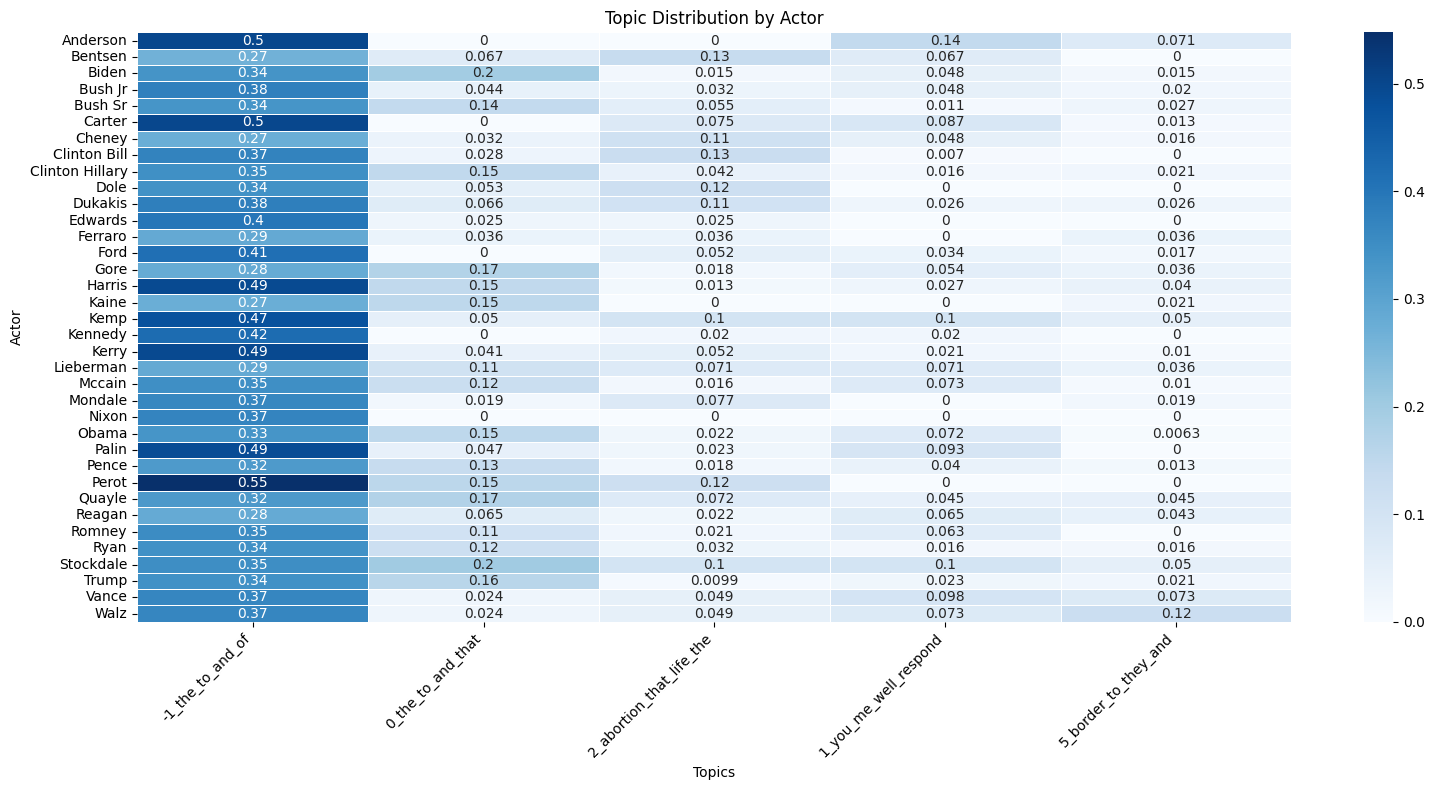

In [15]:
model, _, topics, _ = run_bertopic_over_metadata(df_debates, groupby_col="actor")
visualize_topic_distribution_by_group(model, df_short, topics, groupby_col="actor", top_n_topics=5)

2025-05-23 18:40:14,802 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Creating new BERTopic model using embedding model: all-MiniLM-L6-v2
Fitting BERTopic...


2025-05-23 18:40:19,112 - BERTopic - Dimensionality - Completed ✓
2025-05-23 18:40:19,118 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 18:40:19,281 - BERTopic - Cluster - Completed ✓
2025-05-23 18:40:19,289 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:40:19,727 - BERTopic - Representation - Completed ✓
2025-05-23 18:40:20,124 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 18:40:20,140 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 18:40:20,552 - BERTopic - Representation - Completed ✓
2025-05-23 18:40:20,555 - BERTopic - Topic reduction - Reduced number of topics from 72 to 16


Computing topic frequency over 'party'...


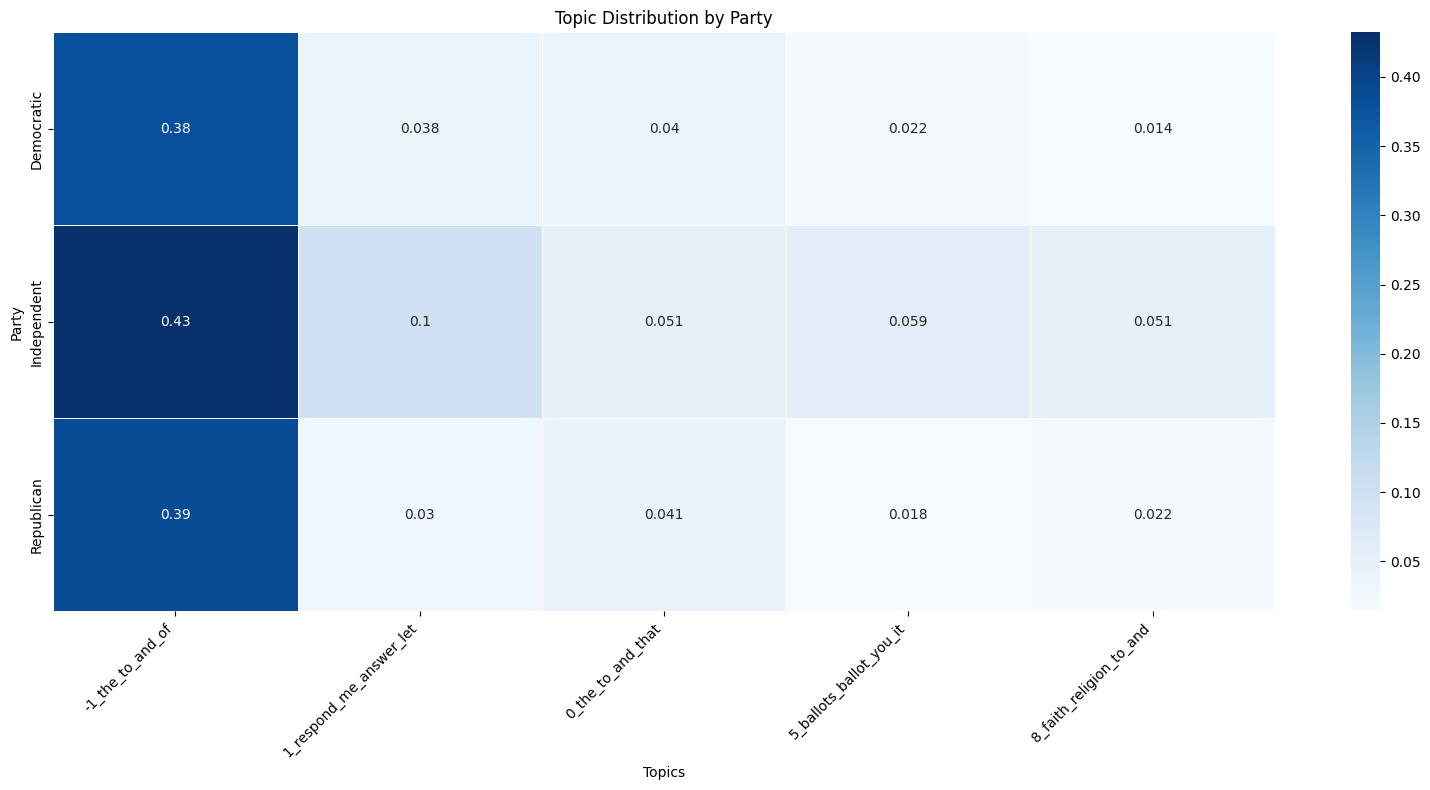

In [16]:
model, _, topics, _ = run_bertopic_over_metadata(df_debates, groupby_col="party")
visualize_topic_distribution_by_group(model, df_short, topics, groupby_col="party", top_n_topics=5)